# L2: Multimodal Search

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
```
    !pip install -U weaviate-client
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Setup
### Load environment variables and API keys

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")

## Connect to Weaviate

In [ ]:
import weaviate, os

client = weaviate.connect_to_embedded(
    version="1.24.21",
    environment_variables={
        "ENABLE_MODULES": "backup-filesystem,multi2vec-palm",
        "BACKUP_FILESYSTEM_PATH": "/home/jovyan/work/L2/backups",
    },
    headers={
        "X-PALM-Api-Key": EMBEDDING_API_KEY,
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 223


## Create the Collection

In [ ]:
from weaviate.classes.config import Configure

# Just checking if you ever need to re run it
if(client.collections.exists("Animals")):
    client.collections.delete("Animals")
    
client.collections.create(
    name="Animals",
    vectorizer_config=Configure.Vectorizer.multi2vec_palm(
        image_fields=["image"],
        video_fields=["video"],
        project_id="semi-random-dev",
        location="us-central1",
        model_id="multimodalembedding@001",
        dimensions=1408,        
    )
)

## Helper functions

In [5]:
import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

## Insert Images into Weaviate


In [6]:
animals = client.collections.get("Animals")

source = os.listdir("./source/animal_image/")

with animals.batch.rate_limit(requests_per_minute=100) as batch:
    for name in source:
        print(f"Adding {name}")
        
        path = "./source/image/" + name
    
        batch.add_object({
            "name": name,            # name of the file
            "path": path,            # path to the file to display result
            "image": toBase64(path), # this gets vectorized - "image" was configured in vectorizer_config as the property holding images
            "mediaType": "image",    # a label telling us how to display the resource 
        })

Adding cat1.jpg
Adding dog3.jpg
Adding dog1.jpg
Adding cat3.jpg
Adding meerkat2.jpg
Adding cat2.jpg
Adding meerkat1.jpg
Adding dog2.jpg
Adding meerkat3.jpg


<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

In [7]:
# Check for failed objects
if len(animals.batch.failed_objects) > 0:
    print(f"Failed to import {len(animals.batch.failed_objects)} objects")
    for failed in animals.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("No errors")

Failed to import 9 objects
e.g. Failed to import object with error: update vector: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
e.g. Failed to import object with error: update vector: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
e.g. Failed to import object with error: update vector: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
e.g. Failed to import 

## Insert Video Files into Weaviate
> Note: the input video must be at least 4 seconds long.

In [10]:
animals = client.collections.get("Animals")

source = os.listdir("./source/video/")

for name in source:
    print(f"Adding {name}")
    path = "./source/video/" + name    

    # insert videos one by one
    animals.data.insert({
        "name": name,
        "path": path,
        "video": toBase64(path),
        "mediaType": "video"
    })

Adding meerkat-watch.mp4


{"action":"requests_total","api":"rest","class_name":"Animals","error":"update vector: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.","level":"error","msg":"unexpected error","query_type":"objects","time":"2025-08-27T15:00:55Z"}


UnexpectedStatusCodeError: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.'}]}.

In [11]:
# Check for failed objects
if len(animals.batch.failed_objects) > 0:
    print(f"Failed to import {len(animals.batch.failed_objects)} objects")
    for failed in animals.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("No errors")

No errors


## Check count
> Total count should be 15 (9x image + 6x video)

In [19]:
agg = animals.aggregate.over_all(
    group_by="mediaType"
)

for group in agg.groups:
    print(group)

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Build MultiModal Search
### Helper Functions

In [20]:
# Helper functions to display results
import json
from IPython.display import Image, Video

def json_print(data):
    print(json.dumps(data, indent=2))

def display_media(item):
    path = item["path"]

    if(item["mediaType"] == "image"):
        display(Image(path, width=300))

    elif(item["mediaType"] == "video"):
        display(Video(path, width=300))

In [21]:
import base64, requests

# Helper function – get base64 representation from an online image
def url_to_base64(url):
    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode('utf-8')

# Helper function - get base64 representation from a local file
def file_to_base64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

## Text to Media Search

> Where the fun begins!

In [22]:
animals = client.collections.get("Animals")

response = animals.query.near_text(
    query="dog playing with stick",
    return_properties=['name','path','mediaType'],
    limit=3
)

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize keywords: remote client vectorize: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

In [23]:
for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

NameError: name 'response' is not defined

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern.

## Image to Media Search

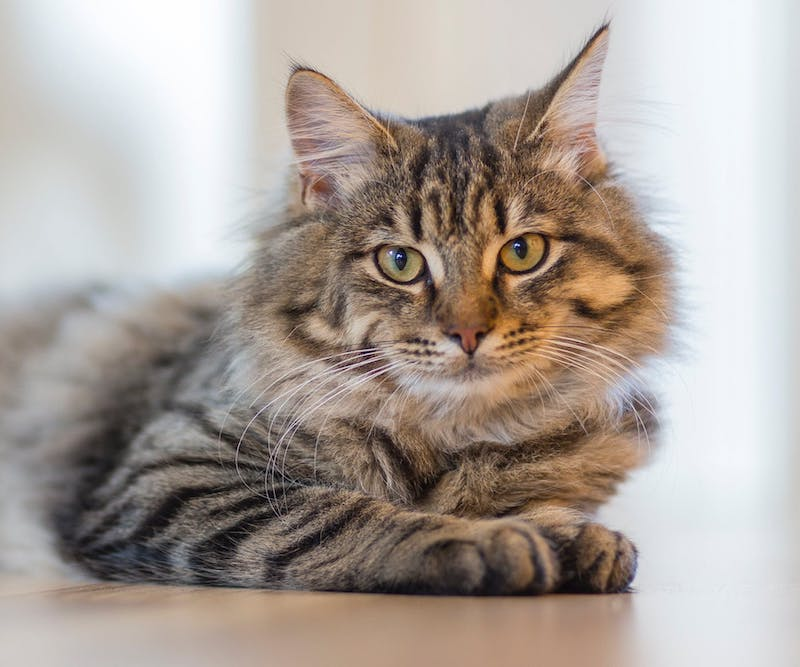

In [24]:
# Use this image as an input for the query
Image("./test/test-cat.jpg", width=300)

In [25]:
# The query
response = animals.query.near_image(
    near_image=file_to_base64("./test/test-cat.jpg"),
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize image: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

## Image search - from web URL

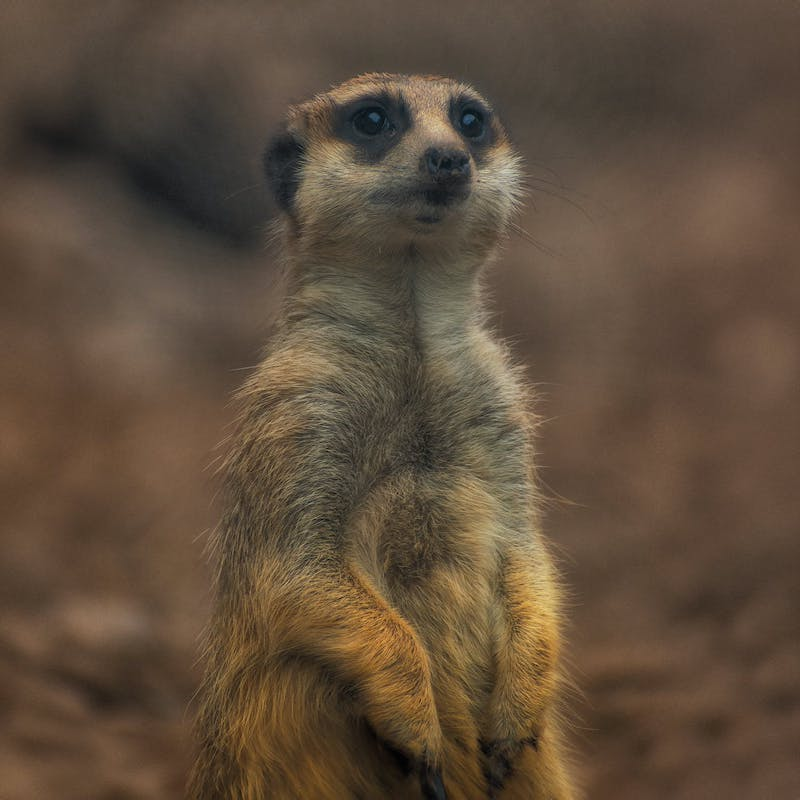

In [26]:
Image("https://raw.githubusercontent.com/weaviate-tutorials/multimodal-workshop/main/2-multimodal/test/test-meerkat.jpg", width=300)

In [27]:
# The query
response = animals.query.near_image(
    near_image=url_to_base64("https://raw.githubusercontent.com/weaviate-tutorials/multimodal-workshop/main/2-multimodal/test/test-meerkat.jpg"),
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize image: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

## Video to Media Search
> Note: the input video must be at least 4 seconds long.

In [28]:
Video("./test/test-meerkat.mp4", width=400)

In [29]:
from weaviate.classes.query import NearMediaType

response = animals.query.near_media(
    media=file_to_base64("./test/test-meerkat.mp4"),
    media_type=NearMediaType.VIDEO,
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    # json_print(obj.properties)
    display_media(obj.properties)

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: vectorize params: vectorize params: vectorize params: vectorize video: connection to Google failed with status: 401 error: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project..

## Visualizing a Multimodal Vector Space

> To make this more exciting, let's loadup a large dataset!

In [30]:
import numpy as np
import sklearn.datasets
import pandas as pd
import umap
import umap.plot
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/usr/local/lib/python3.11/site-packages/numba/core/decorators.py:161: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is True and supplying this argument has no effect.
  warnings.warn(msg, NumbaDeprecationWarning)


## Load vector embeddings and mediaType from Weaviate 

In [31]:
client.backup.restore(
    backup_id="resources-img-and-vid",
    include_collections="Resources",
    backend="filesystem"
)

# It can take a few seconds for the "Resources" collection to be ready.
# We add 5 seconds of sleep to make sure it is ready for the next cells to use.
import time
time.sleep(5)

{"action":"try_restore","backend":"filesystem","backup_id":"resources-img-and-vid","level":"info","msg":"","time":"2025-08-27T15:02:21Z","took":2796210}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-08-27T15:02:22Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 3.710706ms","time":"2025-08-27T15:02:22Z"}
{"action":"restore","backup_id":"resources-img-and-vid","class":"Resources","level":"info","msg":"successfully restored","time":"2025-08-27T15:02:22Z"}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"backup restored successfully","time":"2025-08-27T15:02:22Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-08-27T15:02:22Z","took":137412652}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","

In [32]:
# Collection named "Resources"
collection = client.collections.get("Resources")

embs = []
labs = []
for item in collection.iterator(include_vector=True):
    #print(item.properties)\
    labs.append(item.properties['mediaType'])
    embs.append(item.vector)

In [33]:
embs2 = [emb['default'] for emb in embs]

emb_df = pd.DataFrame(embs2)
labels = pd.Series(labs)

labels[labels=='image'] = 0
labels[labels=='video'] = 1

>Note: this might take some minutes to complete the execution.

In [34]:
%%time
mapper2 = umap.UMAP().fit(emb_df)

CPU times: user 53.8 s, sys: 1.37 s, total: 55.2 s
Wall time: 19.5 s


## Plot the embeddings

<Figure size 1000x800 with 0 Axes>

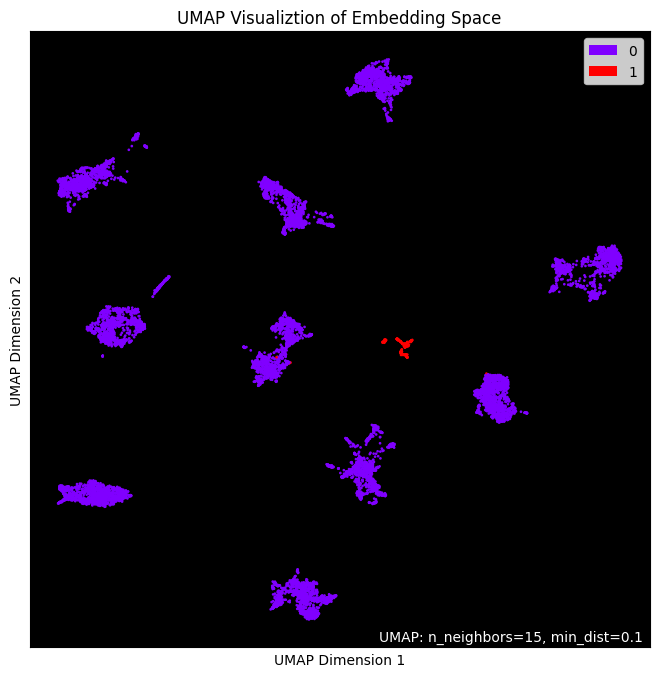

In [35]:
plt.figure(figsize=(10, 8))
umap.plot.points(mapper2, labels=labels, theme='fire')

# Show plot
plt.title('UMAP Visualiztion of Embedding Space')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show();

## Interactive plot of vectors

>Note: Once you run the following cell, please be aware that on the right-hand side,  there are special buttons available. These buttons enable you to perform various functions such as highlighting and more.

In [ ]:
umap.plot.output_notebook()

p = umap.plot.interactive(mapper2, labels=labels, theme='fire')

umap.plot.show(p)

Loading BokehJS ...

## Close the connection to Weaviate

In [ ]:
client.close()

{"action":"restapi_management","level":"info","msg":"Shutting down... ","time":"2025-08-27T15:02:49Z"}
{"action":"restapi_management","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2025-08-27T15:02:49Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:552cf664-78fa-4eb5-8c58-6aec98de39ef Type:TERMINATE Version:1.24.21 NumObjects:13594 OS:linux Arch:amd64 UsedModules:[multi2vec-google-vertex-ai]}","time":"2025-08-27T15:02:49Z"}


### Try it yourself! 

Run any of the cells above with your own images or URL for images or videos!